<a id="0"></a> <br>
 # Table of Contents  
1. [Importing Libraries](#1)     
1. [Reading the Data](#2) 
1. [Data Transformation](#3) 
1. [RMSE Index Calculation](#4)     
1. [Storing RMSE Data](#5)     
1. [São Paulo RMSE Results](#6)     
1. [Data Visualization](#7)       
    1. [RMSE Two-Dimensional Heat Maps](#8)      
    1. [RMSE Through Time](#9)     

<a id="1"></a>
## 1. Importing Libraries

In [2]:
import xarray as xr
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt  

<a id="2"></a>
## 2. Reading the Data

In [3]:
# Opening the data as xarray datasets
ds_o = xr.open_dataset('observation.nc')
ds_f = xr.open_dataset('forecast.nc')

<a id="3"></a>
## 3. Data Transformation
Here we perform some simple transformations to organize the data and have the temperatures in the same unities (°Celsius). 
We also take the observed latitudes and longitudes to be our true coordinates and be able to combine these two datasets for easier calculation.

In [4]:
# Renaming variables and dimensions
ds_o = ds_o.rename_vars(name_dict={'temperatura': 'temp_o'}).rename_dims(dims_dict={'time': 'datetime'})
ds_f = ds_f.rename_vars(name_dict={'t2m': 'temp_f'}).rename_dims(dims_dict={'time': 'datetime'})

In [5]:
# Converting forecasted temperature from Kelvin to Celsius
ds_f['temp_f'] -=273.15

# Setting forecast coordinates to be the same as our observed coordinates
ds_f['lat'] = ds_o['lat']
ds_f['lon'] = ds_o['lon']

In [6]:
# Combining forecast and observation datasets by coordinates
ds_combined = xr.combine_by_coords([ds_f, ds_o])
ds_combined

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 37, datetime: 72)
Coordinates:
  * lat      (lat) float32 -25.29 -25.07 -24.85 -24.63 ... -20.37 -20.14 -19.92
  * lon      (lon) float32 -52.99 -52.75 -52.51 -52.26 ... -44.74 -44.49 -44.25
  * time     (datetime) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00
Dimensions without coordinates: datetime
Data variables:
    temp_f   (datetime, lat, lon) float32 24.73 24.48 24.26 ... 18.03 17.69
    temp_o   (datetime, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.1 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Apr 19 18:43:01 2018: cdo remapbil,gridfile observation...
    CDO:          Climate Data Operators version 1.9.1 (http://mpimet.mpg.de/...

<a id="4"></a>
## 4. RMSE Index Calculation
The RMSE is used to evaluate the model performance for our forecast. We calculate it first for all points ir our dataset with the predicted value as the forecasted temperature (temp_f) and the observed value as the observed temperature (temp_o) using the formula below. This index is calculated in Celsius.

RMSE = $\sqrt((f - o)^2)$

In [7]:
# Add new variable RMSE to our dataset
ds_combined['RMSE'] = np.sqrt((ds_combined['temp_f'] - ds_combined['temp_o'])**2)

To get this metric for every period of 6 hours I create a new variable called period that takes our time variable and resample it for a frequency of 6h. We then group or data by this period and take the mean value to obtain the RMSE.

In [8]:
# Creating a variable for periods of 6h and taking the mean values grouping by this period
ds_combined.coords['period'] = ds_combined.time.dt.floor('6h')
ds_6h = ds_combined.groupby('period').mean()

<a id="5"></a>
## 5. Storing RMSE Data

In [9]:
# Writing metadata for the new variable stored in the results dataset
ds_6h.RMSE.attrs['standard_name'], ds_6h.RMSE.attrs['long_name'] = 'RMSE', 'Root Mean Squared Error'
ds_6h.RMSE.attrs['units'] =  'Celsius'

In [20]:
# Convert to nc file and store it in rmse_results.nc
ds_6h.to_netcdf(path='rmse.nc', mode='w', format="NETCDF4_CLASSIC")

<a id="6"></a>
## 6. São Paulo RMSE Results 
The data for São Paulo is obtained with the coordinates X = 8 and Y = 26. We select the data for São Paulo using these coordinates to create two subdatasets: one with RMSE for all time values and the other for RMSE calculated for our 6h period.

In [11]:
print(f'São Paulo Coordinates \n Latitude: {ds_combined.lat[8].values}, Longitude: {ds_combined.lon[26].values}')

São Paulo Coordinates 
 Latitude: -23.52492904663086, Longitude: -46.67829895019531


In [12]:
# Selecting São Paulo data with lat and lon coordinates
ds_sp_6h = ds_6h.sel(lat = ds_6h.lat[8], lon = ds_6h.lon[26])
ds_sp = ds_combined.sel(lat=ds_combined.lat[8], lon=ds_combined.lon[26])

In [13]:
# Format date periods for the maps visualization
ds_6h['period'] = ds_6h.period.dt.strftime("%b %d, %H:%M")

In [14]:
ds_6h

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 37, period: 12)
Coordinates:
  * lat      (lat) float32 -25.29 -25.07 -24.85 -24.63 ... -20.37 -20.14 -19.92
  * lon      (lon) float32 -52.99 -52.75 -52.51 -52.26 ... -44.74 -44.49 -44.25
  * period   (period) object 'Apr 14, 00:00' 'Apr 14, 06:00' ... 'Apr 16, 18:00'
Data variables:
    temp_f   (period, lat, lon) float32 23.65 23.32 23.01 ... 19.94 19.27 18.87
    temp_o   (period, lat, lon) float32 22.15 20.3 18.17 ... 21.15 20.56 20.46
    RMSE     (period, lat, lon) float32 1.498 3.014 4.843 ... 1.21 1.295 1.591
Attributes:
    CDI:          Climate Data Interface version 1.9.1 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Apr 19 18:43:01 2018: cdo remapbil,gridfile observation...
    CDO:          Climate Data Operators version 1.9.1 (http://mpimet.mpg.de/...

<a id="7"></a>
## 7. Data Visualization
Finally, we will performe some data visualization. We first want to visualize the RSME for each period of 6h through 2-dimensional heat maps with our latitude and longitude coordinates. These color maps allows us to visualize where RMSE is lower or higher for each time period interval.

In [15]:
sns.set_theme()

<a id="8"></a>
7.1 RMSE Two-Dimensional Heat Maps 

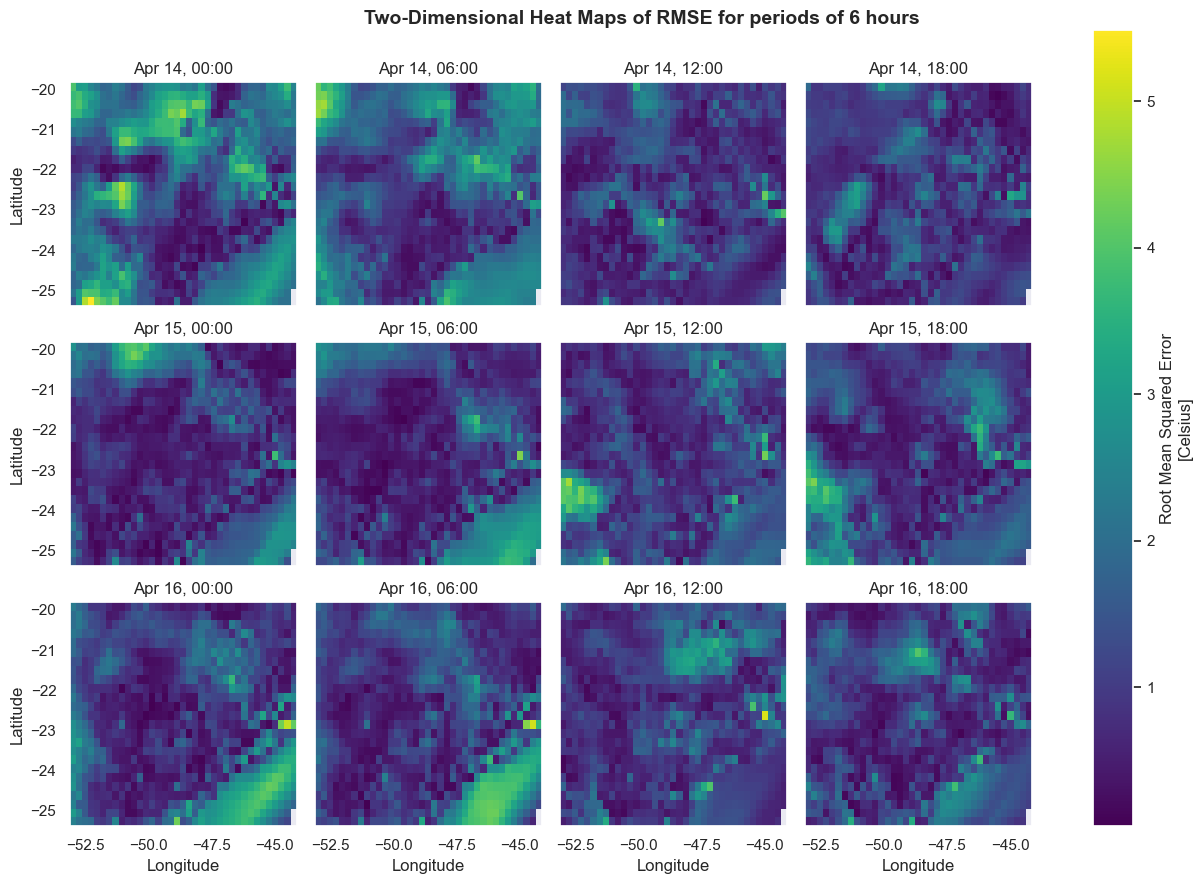

In [45]:
maps = ds_6h.RMSE.plot(x="lon", y="lat", col="period", col_wrap=4)
maps.set_axis_labels('Longitude')
maps.set_ylabels('Latitude')
maps.set_titles(template='{value}')
maps.fig.suptitle('Two-Dimensional Heat Maps of RMSE for periods of 6 hours', 
                  size=14, fontweight='bold')
maps.fig.subplots_adjust(top=0.9, right=0.8)

<a id="9"></a>
7.2 RMSE Through Time

We also want to visualize graphically the RMSE for São Paulo through time using the subdatasets we created. I chose to show it both in a barplot (for the Mean RMSE calculated every 6h) and with a lineplot, comparing it with the RMSE calculated hourly. We're able to notice through this plot that the mean RMSE models the hourly RMSE pretty well.

C:\Users\menezebe\AppData\Local\Temp\ipykernel_11956\2625425798.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(ds_6h.period.values)


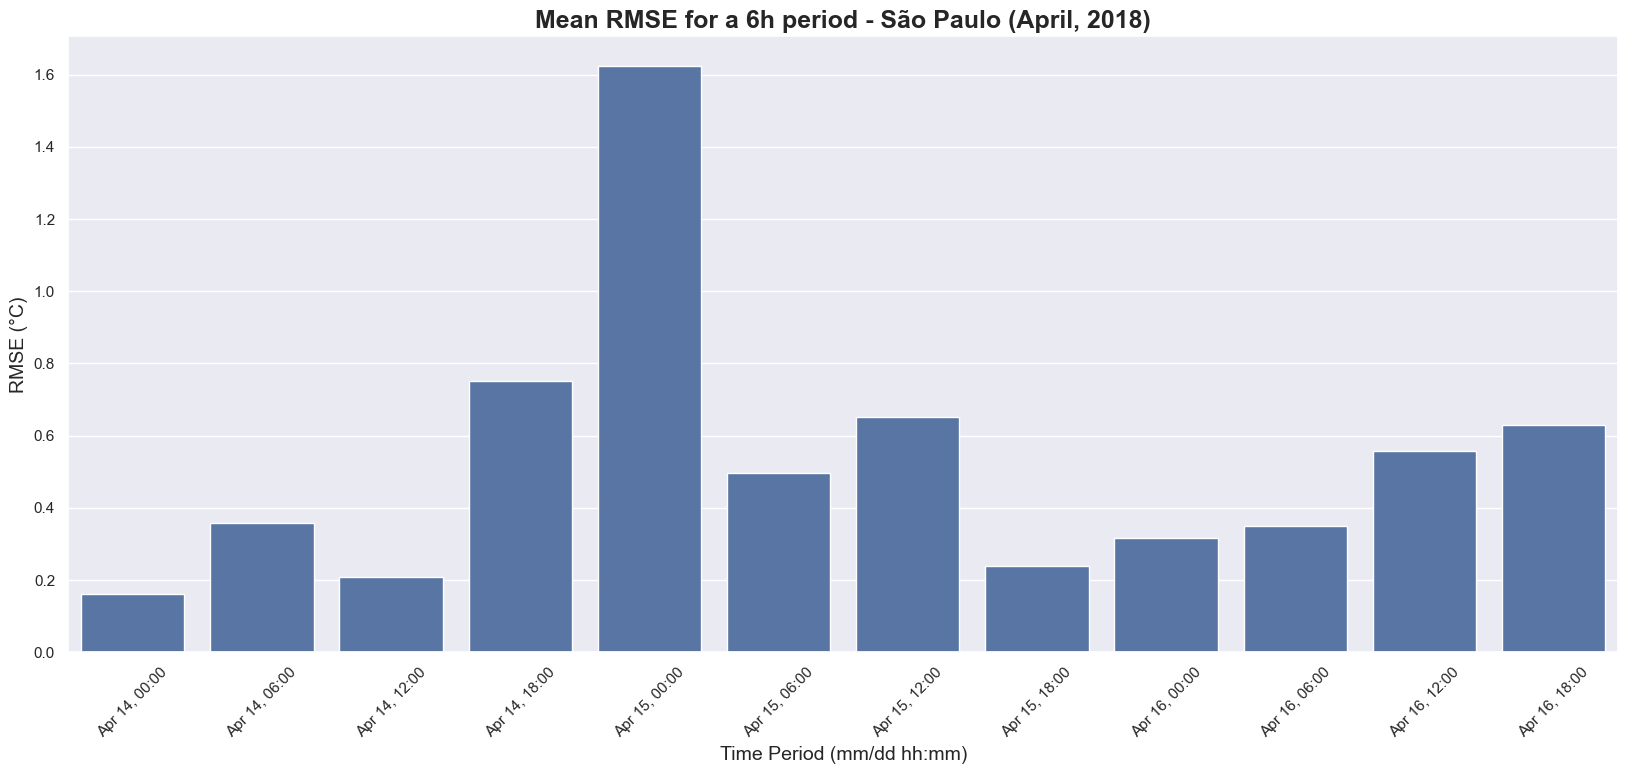

In [17]:
plt.figure(figsize=(20, 8))
_ = plt.xticks(rotation=45) 
bar = sns.barplot(x=ds_sp_6h.period, y=ds_sp_6h.RMSE)
plt.title('Mean RMSE for a 6h period - São Paulo (April, 2018)', 
          fontsize=18, fontweight='bold')
bar.set_xticklabels(ds_6h.period.values)
plt.xlabel('Time Period (mm/dd hh:mm)', fontsize=14)
plt.ylabel('RMSE (°C)', fontsize=14)
plt.show()

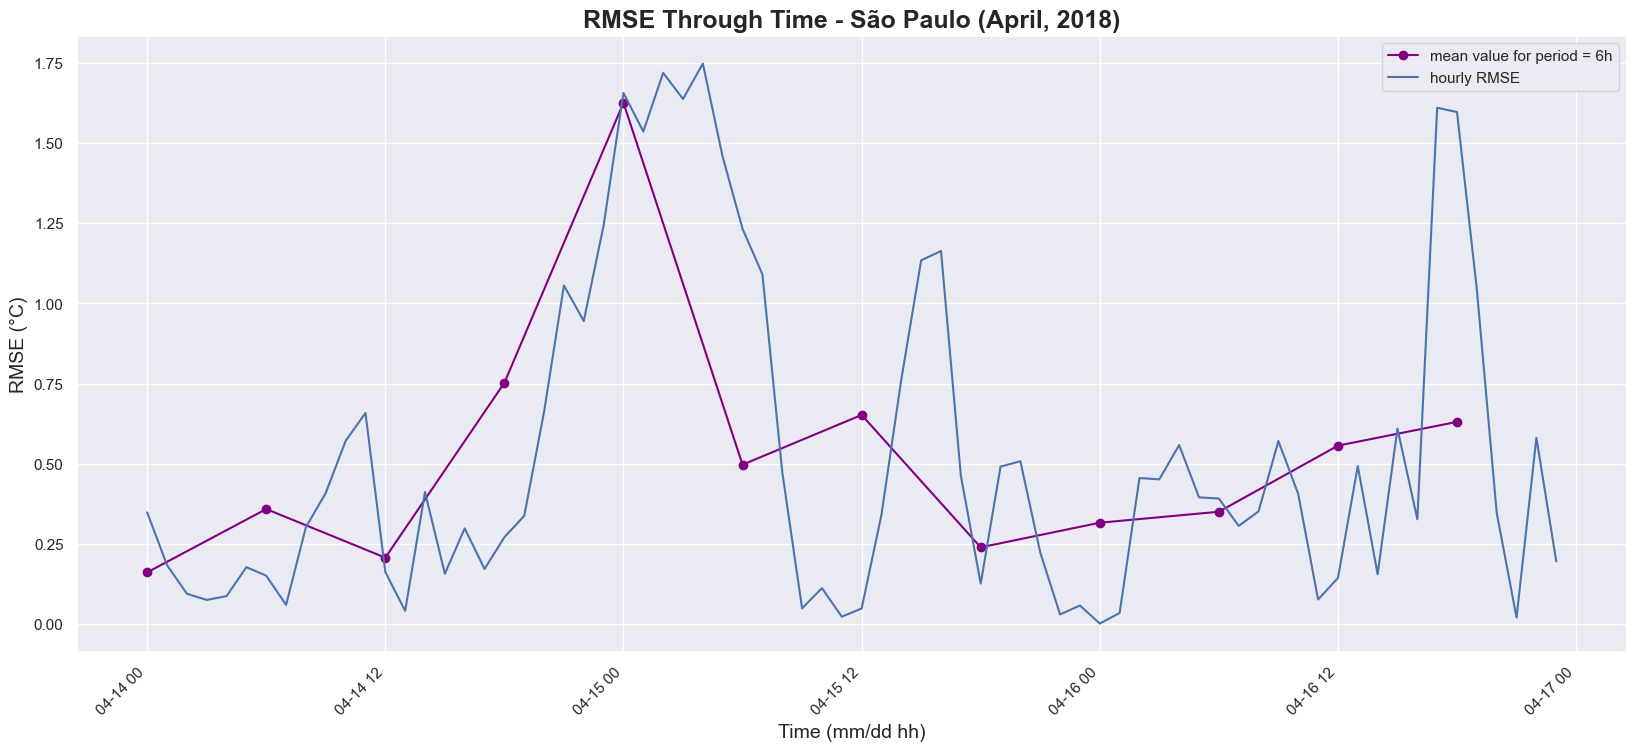

In [18]:
plt.figure(figsize=(20, 8))
ds_sp_6h.RMSE.plot(x = 'period', color= 'purple',  marker='o')
ds_sp.RMSE.plot(x = 'time')
_ = plt.xticks(rotation=45) 
plt.xlabel('Time (mm/dd hh)', fontsize=14)
plt.ylabel('RMSE (°C)', fontsize=14)
plt.title('RMSE Through Time - São Paulo (April, 2018)', fontsize=18, fontweight='bold')
plt.legend(['mean value for period = 6h', 'hourly RMSE'], loc='upper right')
plt.show()
